In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader
from datasets import Dataset

# Load Dataset

In [8]:
df = pd.read_csv('/content/Combined Data.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [9]:
df1 = df[df['status'] == 'Normal'].sample(n=2000, random_state=42).reset_index(drop=True)
df2 = df[df['status'] == 'Depression'].sample(n=2000, random_state=42).reset_index(drop=True)
df3 = df[df['status'] == 'Suicidal'].sample(n=2000, random_state=42).reset_index(drop=True)
df4 = df[df['status'] == 'Anxiety'].sample(n=2000, random_state=42).reset_index(drop=True)
df5 = df[df['status'] == 'Bipolar'].sample(n=2000, random_state=42).reset_index(drop=True)
df6 = df[df['status'] == 'Stress'].sample(n=2000, random_state=42).reset_index(drop=True)
df7 = df[df['status'] == 'Personality disorder'].sample(n=1200, random_state=42).reset_index(drop=True)

df = pd.concat([df1, df2, df3, df4, df5, df6, df7]).sample(13200, random_state=42).reset_index(drop=True)

In [10]:
df.head()

,statement,status
0,"My family has given me so much, but also taken...",Suicidal
1,She wont call the cops because her counselor c...,Stress
2,Very anxious and uncomfortable after professor...,Anxiety
3,I was terrified and scared and couldn't get aw...,Stress
4,"Depressive personality disorder? Hi, from what...",Personality disorder


In [11]:
df['status'].value_counts()

,count
status,
Suicidal,2000
Stress,2000
Anxiety,2000
Bipolar,2000
Normal,2000
Depression,2000
Personality disorder,1200


In [ ]:
# df = df.sample(n=6000, random_state=42).reset_index(drop=True)
# df.head()

,statement,status
0,Just as the the title says. I feel like one is...,Depression
1,a blackened sky encroached tugging behind it m...,Depression
2,"It gives you insomnia, which in turn makes you...",Depression
3,"Hello all, I'm a new submitter to this channel...",Normal
4,Thank God the CB is over for Eid,Normal


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  12926 non-null  object
 1   status     13200 non-null  object
dtypes: object(2)
memory usage: 206.4+ KB


In [13]:
df.dropna(inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12926 entries, 0 to 13199
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  12926 non-null  object
 1   status     12926 non-null  object
dtypes: object(2)
memory usage: 303.0+ KB


In [15]:
df['status'].value_counts()

,count
status,
Suicidal,2000
Depression,2000
Normal,1999
Anxiety,1978
Stress,1937
Bipolar,1936
Personality disorder,1076


# Data Preprocessing

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [18]:
def clean_statement(text):

  # lower casing
  text = text.lower()

  # keep only latters
  text = re.sub(r'[^a-zA-Z\s]','', text)

  # Tokenization (spliting)
  words = text.split()
  words = [word for word in words if word not in stop_words]

  return ' '.join(words)

df['statement'] = df['statement'].apply(clean_statement)

In [19]:
df.head()

,statement,status
0,family given much also taken away much cannot ...,Suicidal
1,wont call cops counselor confirmed would take ...,Stress
2,anxious uncomfortable professor made us watch ...,Anxiety
3,terrified scared couldnt get away said joking ...,Stress
4,depressive personality disorder hi gather depr...,Personality disorder


In [20]:
df['status'].value_counts()

,count
status,
Suicidal,2000
Depression,2000
Normal,1999
Anxiety,1978
Stress,1937
Bipolar,1936
Personality disorder,1076


# handling Embalance data

In [ ]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# x = df.drop(columns=['status'])
# y = df['status']

# x_resample, y_resample = ros.fit_resample(x, y)

In [ ]:
# df = pd.concat([x_resample, y_resample], axis=1)

# print(df['status'].value_counts())

status
Depression              1885
Normal                  1885
Suicidal                1885
Anxiety                 1885
Bipolar                 1885
Stress                  1885
Personality disorder    1885
Name: count, dtype: int64


# Encoding

In [21]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['status'])
df.head()

,statement,status,label
0,family given much also taken away much cannot ...,Suicidal,6
1,wont call cops counselor confirmed would take ...,Stress,5
2,anxious uncomfortable professor made us watch ...,Anxiety,0
3,terrified scared couldnt get away said joking ...,Stress,5
4,depressive personality disorder hi gather depr...,Personality disorder,4


### Train Test split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df['statement'], df['label'], test_size=0.2, random_state=42)

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(x_train), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(x_test), padding=True, truncation=True, max_length=200)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'],
                                   'attention_mask': train_encodings['attention_mask'],
                                   'labels': y_train.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'],
                                   'attention_mask': test_encodings['attention_mask'],
                                   'labels': y_test.tolist()})

# Fine Tune Model

In [25]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(encoder.classes_))

training_args = TrainingArguments(
    output_dir = './updated_results',
    eval_strategy ='epoch',
    save_strategy ='epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay = 0.01,
    logging_dir = './logs',
    logging_steps = 10,
    lr_scheduler_type = 'linear',
    warmup_steps = 500,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    save_total_limit=3,
    gradient_accumulation_steps=2
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 24ms0026 (23je0939-spe-iit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,1.143100,1.013394
2,0.651500,0.701398
3,0.515600,0.637369
4,0.299400,0.622254
5,0.274500,0.635064


TrainOutput(global_step=1620, training_loss=0.7098600118248551, metrics={'train_runtime': 1975.4107, 'train_samples_per_second': 26.172, 'train_steps_per_second': 0.82, 'total_flos': 5313848529000000.0, 'train_loss': 0.7098600118248551, 'epoch': 5.0})

# Evaluation

In [27]:
# Predictions
predictions, labels, _ = trainer.predict(test_dataset)

# convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

In [28]:
print(classification_report(y_test, predicted_labels, target_names=encoder.classes_))


                      precision    recall  f1-score   support

             Anxiety       0.82      0.87      0.84       385
             Bipolar       0.84      0.84      0.84       372
          Depression       0.71      0.62      0.67       440
              Normal       0.92      0.88      0.90       420
Personality disorder       0.86      0.75      0.80       217
              Stress       0.74      0.80      0.77       374
            Suicidal       0.67      0.76      0.71       378

            accuracy                           0.79      2586
           macro avg       0.80      0.79      0.79      2586
        weighted avg       0.79      0.79      0.79      2586



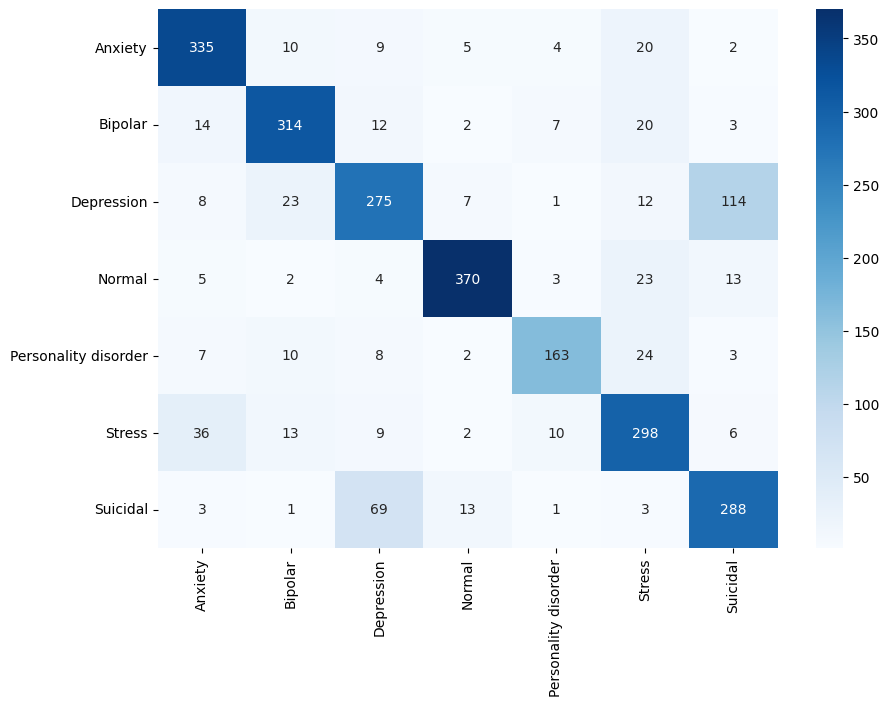

In [29]:
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)

plt.show()

# Save model and Load model

In [30]:
trainer.save_model("updated_mental_status_bert")           # saves model to /content/saved_model
tokenizer.save_pretrained("updated_mental_status_bert")   # saves tokenizer config + vocab

('updated_mental_status_bert/tokenizer_config.json',
 'updated_mental_status_bert/special_tokens_map.json',
 'updated_mental_status_bert/vocab.txt',
 'updated_mental_status_bert/added_tokens.json')

In [31]:
!zip -r updated_mental_status_bert.zip updated_mental_status_bert/

  adding: updated_mental_status_bert/ (stored 0%)
  adding: updated_mental_status_bert/special_tokens_map.json (deflated 42%)
  adding: updated_mental_status_bert/vocab.txt (deflated 53%)
  adding: updated_mental_status_bert/training_args.bin (deflated 51%)
  adding: updated_mental_status_bert/model.safetensors (deflated 7%)
  adding: updated_mental_status_bert/tokenizer_config.json (deflated 75%)
  adding: updated_mental_status_bert/config.json (deflated 55%)


In [32]:
from google.colab import files
files.download("updated_mental_status_bert.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
# Save to file
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)


In [35]:
# Load from file
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


In [36]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer from the saved paths
model = AutoModelForSequenceClassification.from_pretrained("updated_mental_status_bert")
tokenizer = AutoTokenizer.from_pretrained("updated_mental_status_bert")


# Detection system

In [37]:
def detection(text):
  text = clean_statement(text)
  inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=200)

  output = model(**inputs)
  logits = output.logits
  predicted_label = torch.argmax(logits, dim=1).item()

  return label_encoder.inverse_transform([predicted_label])[0]

In [38]:
text = 'I feel hopeless and nothing excites me anymore.'
detection(text)

'Suicidal'

In [39]:
text2 = "I'm always worried, even when there's nothing to worry about."
detection(text2)

'Anxiety'

In [40]:
text = "I’m eating something."
detection(text)

'Normal'

In [41]:
text = "I feel numb and disconnected from my body and surroundings."
detection(text)

'Anxiety'